In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.stats import linregress
from scipy.optimize import fsolve
from rebound import M_to_f
from rotation_tools import RotationSimulation, RotationalState
plt.rcParams.update({'font.size': 18})
plt.rcParams.update({'font.family':"serif"})
true_P = 21.28

## Current state

In [2]:
A, B, C = 0.314, 0.474, 0.542
e = 0.115
e_period = 2022.5 # secular oscillation period in units where hyperion's orbital period is 2pi
M0 = np.radians(295)
N = 100
P = 2*np.pi
ts = np.arange(0, N*P, P/100)

theta0, phi0, psi0 = 0.004, 1.441, 0.427
omega0 = 4.433
omegaa0 = omega0*0.890
omegab0 = omega0*0.067
omegac0 = omega0*0.451
initial_state = RotationalState([theta0, phi0, psi0, omegaa0, omegab0, omegac0])
fid_sim = RotationSimulation(A=A, B=B, C=C, e_forced=e, e_free=0.0, e_period=e_period, n=1.0, M0=M0)
fid_sim.integrate(ts, initial_state, coords='quat')

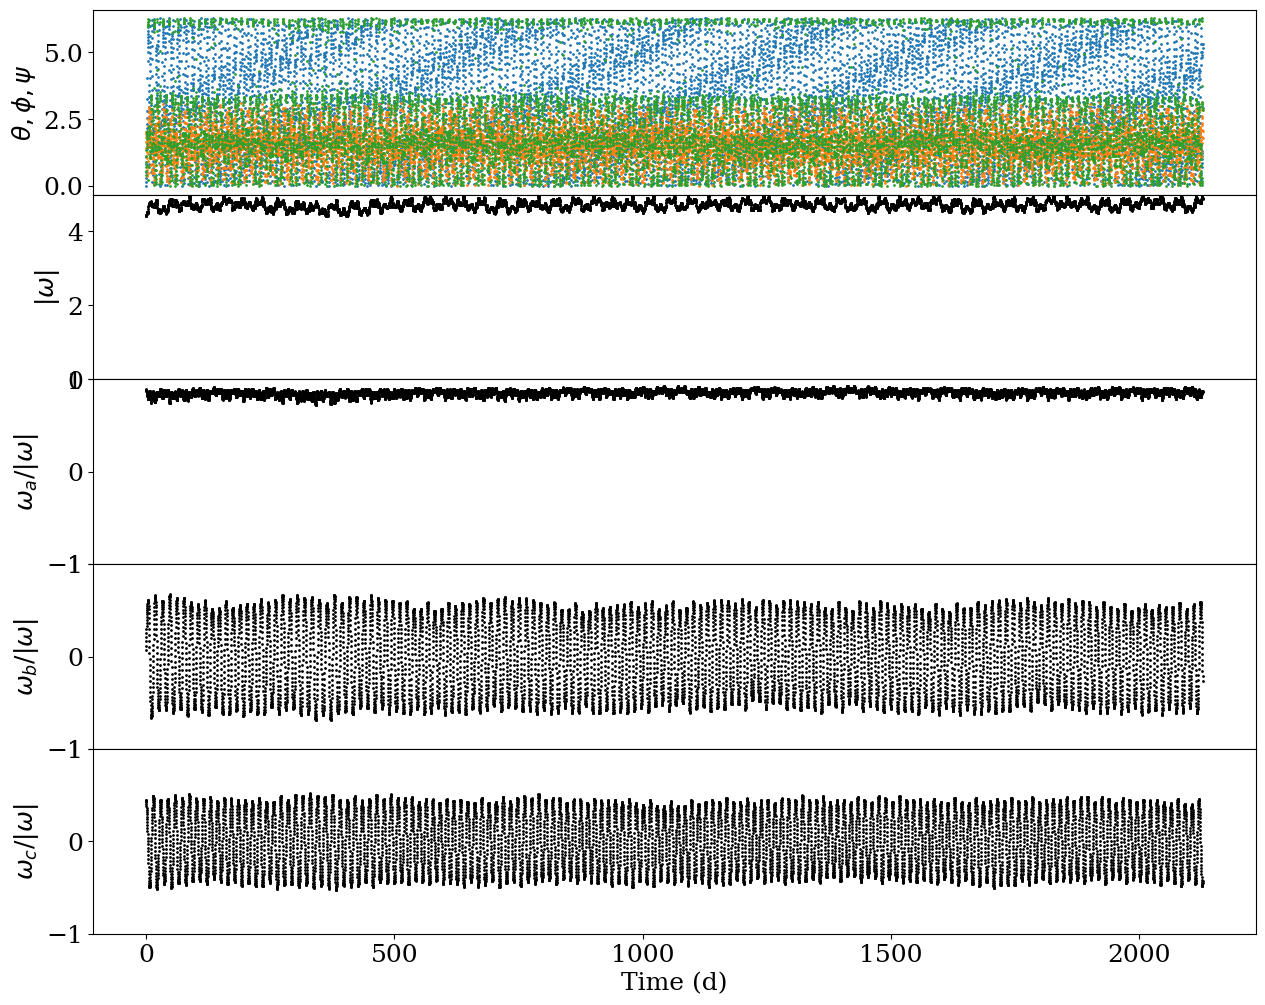

In [3]:
fig, axs = plt.subplots(5, 1, figsize=(15, 12), sharex=True, gridspec_kw={'hspace': 0})
for i in range(3):
    axs[0].scatter(fid_sim.sol.t/(2*np.pi)*true_P, np.remainder(fid_sim.sol.euler[i], 2*np.pi), s=1, alpha=1, linestyle='None')
axs[1].scatter(fid_sim.sol.t/(2*np.pi)*true_P, fid_sim.sol.omega, s=1, alpha=1, color='k')
axs[2].scatter(fid_sim.sol.t/(2*np.pi)*true_P, fid_sim.sol.omegaa/fid_sim.sol.omega, s=1, alpha=1, color='k')
axs[3].scatter(fid_sim.sol.t/(2*np.pi)*true_P, fid_sim.sol.omegab/fid_sim.sol.omega, s=1, alpha=1, color='k')
axs[4].scatter(fid_sim.sol.t/(2*np.pi)*true_P, fid_sim.sol.omegac/fid_sim.sol.omega, s=1, alpha=1, color='k')
axs[0].set_ylabel(r'$\theta, \phi, \psi$')
axs[1].set_ylabel('$|\omega|$')
axs[2].set_ylabel('$\omega_a/|\omega|$')
axs[3].set_ylabel('$\omega_b/|\omega|$')
axs[4].set_ylabel('$\omega_c/|\omega|$')
axs[4].set_xlabel('Time (d)')
axs[1].set_ylim(0, 5)
for ax in axs[2:]:
    ax.set_ylim(-1, 1)

(0.0, 20.0)

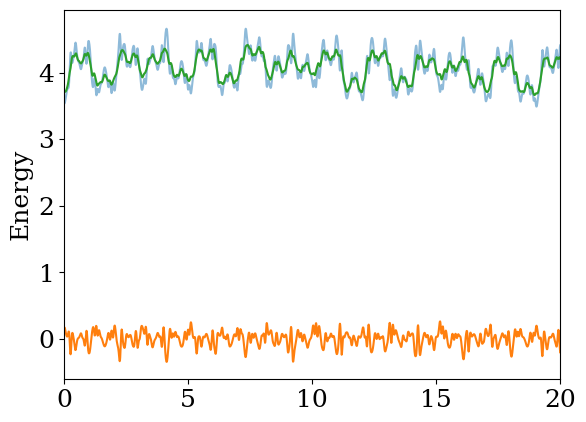

In [4]:
T = 0.5*(fid_sim.A*fid_sim.sol.omegaa**2 + fid_sim.B*fid_sim.sol.omegab**2 + fid_sim.C*fid_sim.sol.omegac**2)
M = fid_sim.sol.t + fid_sim.M0
fs = np.array([fid_sim.get_rf(t)[1] for t in fid_sim.sol.t])
rs = np.array([fid_sim.get_rf(t)[0] for t in fid_sim.sol.t])
alpha, beta, gamma = fid_sim.sol.cosines(fs)
maccullagh_f = (fid_sim.B + fid_sim.C - 2*fid_sim.A)*alpha**2 + \
                (fid_sim.C + fid_sim.A - 2*fid_sim.B)*beta**2 + \
                (fid_sim.A + fid_sim.B - 2*fid_sim.C)*gamma**2
V = -0.5*rs**-5*maccullagh_f
plt.plot(fid_sim.sol.t/(2*np.pi), T, alpha=0.5)
plt.ylabel('Energy')
plt.plot(fid_sim.sol.t/(2*np.pi), V)
plt.plot(fid_sim.sol.t/(2*np.pi), T+V)
plt.xlim(0, 20)

## Integrations

In [5]:
def H_pe(p, e):
    return quad(lambda x: ((1-e**2)/(1 + e*np.cos(M_to_f(e, x))))**-3*np.cos(2*p*x-2*M_to_f(e, x))/(2*np.pi), 0, 2*np.pi)[0]

def func_to_solve(e, p, omega0):
    return np.sqrt(np.abs(H_pe(p, e))) + np.sqrt(np.abs(H_pe(p+0.5, e))) - 1/(2*omega0)

ps = np.array([1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5, 6, 7, 8, 9, 11, 13, 15, 18])
e_bound = np.array([fsolve(func_to_solve, p/20, args=(p, 0.94))[0] for p in ps])

In [6]:
sims = pickle.load(open('/mnt/data-big/mgoldberg/satellites/hyperion_rotation/sols_1.0.p', 'rb'))
print([(sim.e_forced, sim.e_free) for sim in sims])
def get_sim(e_config):
    for sim in sims:
        if (sim.e_forced, sim.e_free) == e_config:
            return sim
    return None
sims[0].sol.quat[0].shape

[(0.01, 0.0), (0.0158, 0.0), (0.0251, 0.0), (0.0398, 0.0), (0.0631, 0.0), (0.1, 0.0), (0.158, 0.0), (0.251, 0.0), (0.398, 0.0), (0.631, 0.0)]


(3000000,)

In [7]:
thresholds = {(0.01, 0.0):0.15, (0.0158, 0.0):0.2, (0.0251, 0.0):0.15, (0.0398, 0.0):0.15, (0.0631, 0.0):0.15,
              (0.1, 0.0):0.2, (0.158, 0.0):0.2, (0.251, 0.0):0.2, (0.398, 0.0):0.2, (0.631, 0.0): 0.5}
for sim in sims:
    sim.sol.cut_NPA(thresholds[(sim.e_forced, sim.e_free)], window_size=200)

In [8]:
analytic_regress = linregress(e_bound, np.log10(ps+0.5))
print(f'Analytical fit: {10**analytic_regress.intercept:.2f} * {10**(analytic_regress.slope/10):.2f}^(e/0.1)')
sim_regress = linregress(*(np.array([(sim.e_forced, np.log10(np.mean(sim.sol.omega))) for sim in sims]).T))
print(f'Fit to simulations: {10**sim_regress.intercept:.2f} * {10**(sim_regress.slope/10):.2f}^(e/0.1)')
sim_npa_regress = linregress(*(np.array([(sim.e_forced, np.log10(np.mean(sim.sol.omega_npa))) for sim in sims]).T))
print(f'Fit to simulations (NPA only): {10**sim_npa_regress.intercept:.2f} * {10**(sim_npa_regress.slope/10):.2f}^(e/0.1)')
sim_regress_quat = linregress(*(np.array([(sim.e_forced, np.log10(np.mean(sim.sol.omega**4)**0.25)) for sim in sims]).T))
print(f'Fit to simulations: {10**sim_regress_quat.intercept:.2f} * {10**(sim_regress_quat.slope/10):.2f}^(e/0.1)')
sim_npa_regress_quat = linregress(*(np.array([(sim.e_forced, np.log10(np.mean(sim.sol.omega_npa**4)**0.25)) for sim in sims]).T))
print(f'Fit to simulations (NPA only): {10**sim_npa_regress_quat.intercept:.2f} * {10**(sim_npa_regress_quat.slope/10):.2f}^(e/0.1)')

Analytical fit: 1.51 * 1.42^(e/0.1)
Fit to simulations: 2.59 * 1.37^(e/0.1)
Fit to simulations (NPA only): 2.13 * 1.36^(e/0.1)
Fit to simulations: 2.88 * 1.37^(e/0.1)
Fit to simulations (NPA only): 2.37 * 1.37^(e/0.1)


0.4614666666666667


Text(0.5, 0, '$|\\omega|$')

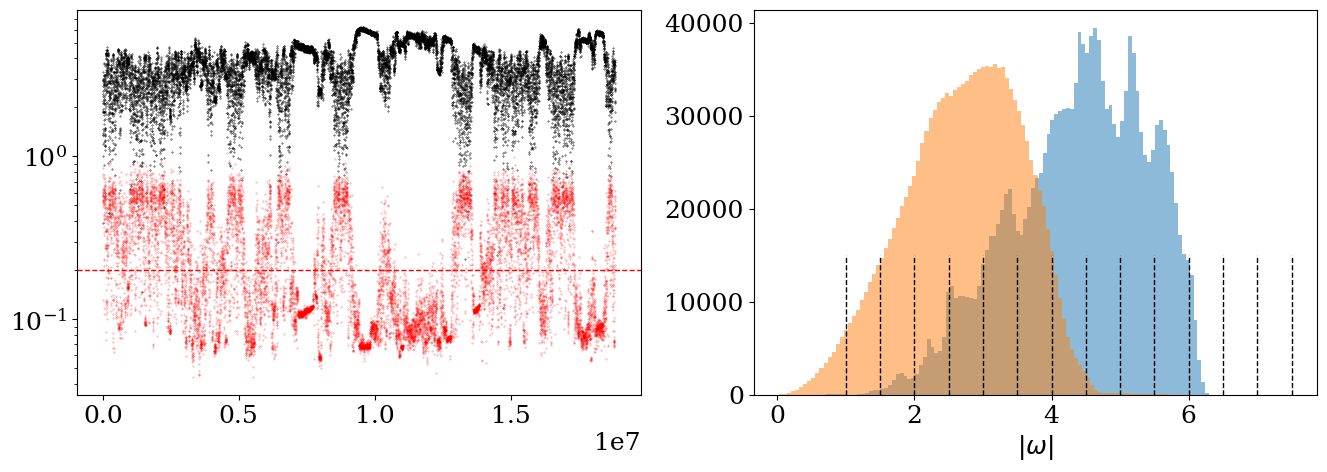

In [9]:
e_config = (0.1, 0.0)
sim = get_sim(e_config)
fig, axs = plt.subplots(1, 2, figsize=(16, 5))
axs[0].scatter(sim.sol.t[::sim.sol.window_size], sim.sol.omega[::sim.sol.window_size], s=0.1, alpha=1, color='k')
axs[0].scatter(sim.sol.t[::sim.sol.window_size], sim.sol.omega_std, s=0.1, alpha=0.5, color='r')
axs[0].axhline(thresholds[e_config], color='r', linestyle='--', linewidth=1)
axs[0].set_yscale('log')

axs[1].hist(sim.sol.omega_pa, bins=100, alpha=0.5);
axs[1].hist(sim.sol.omega_npa, bins=100, alpha=0.5);
print(len(sim.sol.omega_npa)/len(sim.sol.omega))
axs[1].vlines(np.arange(1, 8, 0.5), color='k', linestyle='--', linewidth=1, ymin=0, ymax=15000)
axs[1].set_xlabel('$|\omega|$')

0.4614666666666667


Text(0.5, 0, '$|\\omega|$')

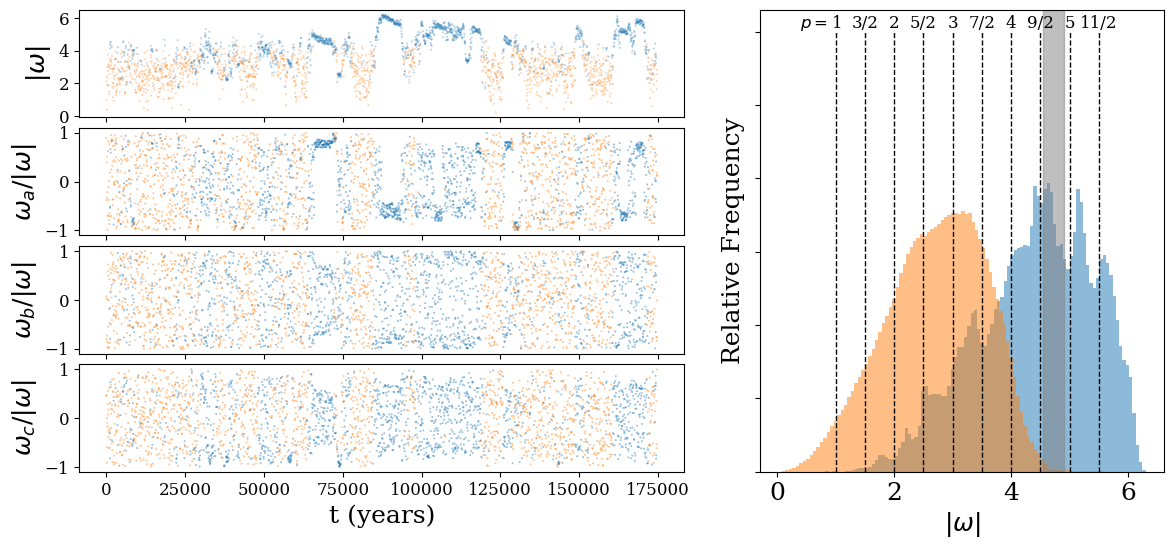

In [10]:
e_config = (0.1, 0.0)
thinning = 1000
sim = get_sim(e_config)
print(len(sim.sol.omega_npa)/len(sim.sol.omega))
fig, axs = plt.subplot_mosaic('''OH
                                 AH
                                 BH
                                 CH''',
                              figsize=(14, 6), gridspec_kw={'hspace':0.1, 'wspace':0.15}, width_ratios=[3,2])
axs['O'].scatter(sim.sol.t[::thinning]/(2*np.pi)*true_P/365.25, sim.sol.omega[::thinning], s=0.1, alpha=0.5, color=np.where(sim.sol.npa_mask[::thinning], 'C1', 'C0'))
axs['A'].scatter(sim.sol.t[::thinning]/(2*np.pi)*true_P/365.25, (sim.sol.omegaa/sim.sol.omega)[::thinning], s=0.1, alpha=0.7, color=np.where(sim.sol.npa_mask[::thinning], 'C1', 'C0'))
axs['B'].scatter(sim.sol.t[::thinning]/(2*np.pi)*true_P/365.25, (sim.sol.omegab/sim.sol.omega)[::thinning], s=0.1, alpha=0.7, color=np.where(sim.sol.npa_mask[::thinning], 'C1', 'C0'))
axs['C'].scatter(sim.sol.t[::thinning]/(2*np.pi)*true_P/365.25, (sim.sol.omegac/sim.sol.omega)[::thinning], s=0.1, alpha=0.7, color=np.where(sim.sol.npa_mask[::thinning], 'C1', 'C0'))
axs['H'].hist(sim.sol.omega_pa, bins=100, alpha=0.5)
axs['H'].hist(sim.sol.omega_npa, bins=100, alpha=0.5)
axs['O'].get_xaxis().set_ticklabels([])
axs['A'].get_xaxis().set_ticklabels([])
axs['B'].get_xaxis().set_ticklabels([])
axs['O'].get_yaxis().set_ticks([0.0, 2.0, 4.0, 6.0])
axs['O'].tick_params(axis='both', which='major', labelsize=12)
axs['A'].tick_params(axis='both', which='major', labelsize=12)
axs['B'].tick_params(axis='both', which='major', labelsize=12)
axs['C'].tick_params(axis='both', which='major', labelsize=12)
axs['C'].set_xlabel('t (years)')
axs['O'].set_ylabel('$|\omega|$')
axs['A'].set_ylabel('$\omega_a/|\omega|$')
axs['B'].set_ylabel('$\omega_b/|\omega|$')
axs['C'].set_ylabel('$\omega_c/|\omega|$')

axs['H'].get_yaxis().set_ticklabels([])
axs['H'].set_ylabel('Relative Frequency')
axs['H'].vlines(np.arange(1, 6, 0.5), color='k', linestyle='--', linewidth=1, ymin=0, ymax=60000)
axs['H'].axvspan(np.percentile(fid_sim.sol.omega, 5), np.percentile(fid_sim.sol.omega, 95), alpha=0.5, color='0.5')
axs['H'].text(1.1, 60600, '$p=$1', fontsize=12, ha='right')
axs['H'].text(1.5, 60600, '3/2', fontsize=12, ha='center')
axs['H'].text(2.0, 60600, '2', fontsize=12, ha='center')
axs['H'].text(2.5, 60600, '5/2', fontsize=12, ha='center')
axs['H'].text(3.0, 60600, '3', fontsize=12, ha='center')
axs['H'].text(3.5, 60600, '7/2', fontsize=12, ha='center')
axs['H'].text(4.0, 60600, '4', fontsize=12, ha='center')
axs['H'].text(4.5, 60600, '9/2', fontsize=12, ha='center')
axs['H'].text(5.0, 60600, '5', fontsize=12, ha='center')
axs['H'].text(5.5, 60600, '11/2', fontsize=12, ha='center')
axs['H'].set_xlabel('$|\omega|$')
# plt.savefig('../figs/omega_dist.pdf', bbox_inches='tight')

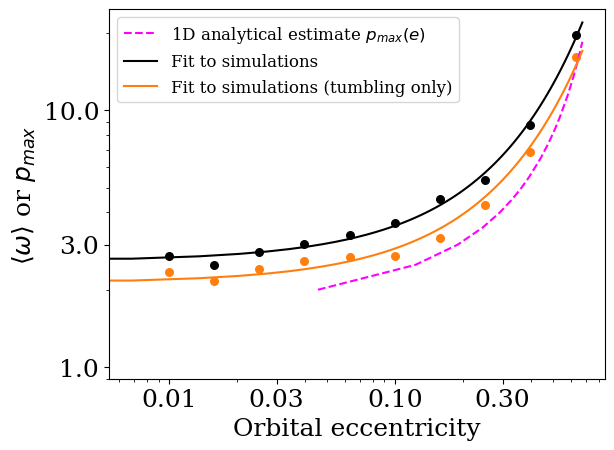

In [11]:
fig, ax = plt.subplots()
for sim in sims:
    if sim.e_free == 0:
        # plt.scatter(e_config[0], np.median(np.linalg.norm(sols[e_config].y[4:], axis=0)), c='k')
        # plt.scatter(e_config[0], np.mean(sols[e_config].omega**4)**0.25, c='k')
        ax.scatter(sim.e_forced, sim.sol.omega.mean(), c='k', s=30)
        ax.scatter(sim.e_forced, sim.sol.omega_npa.mean(), c='C1', s=30)
ax.plot(e_bound, ps+0.5, c='magenta', label='1D analytical estimate $p_{max}(e)$', linestyle='--')
all_es = np.linspace(0, max(e_bound), 100)
ax.plot(all_es, 10**(sim_regress.intercept + sim_regress.slope*all_es), c='k', label='Fit to simulations')
ax.plot(all_es, 10**(sim_npa_regress.intercept + sim_npa_regress.slope*all_es), c='C1', label='Fit to simulations (tumbling only)')
ax.set_xlabel('Orbital eccentricity')
ax.set_ylabel(r'$\langle\omega\rangle$ or $p_{max}$')
ax.set_xscale('log'); 
ax.set_yscale('log')
ax.set_ylim(0.9, None)
ax.xaxis.set_ticks([0.01, 0.03, 0.1, 0.3])
ax.yaxis.set_ticks([1.0, 3.0, 10.0])
ax.xaxis.set_major_formatter(plt.ScalarFormatter())
ax.yaxis.set_major_formatter(plt.FormatStrFormatter('%.1f'))
ax.legend(fontsize=12)
# plt.savefig('../figs/omega_vs_e.pdf', bbox_inches='tight')

## Details and Diagnostics

(0.5, 52.33380301525714)

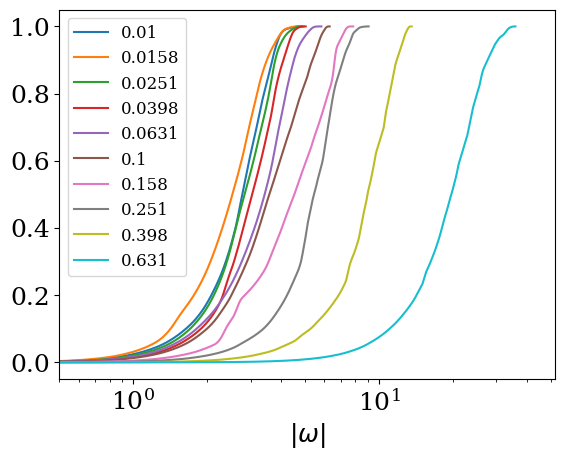

In [12]:
for sim in sims:
    if sim.e_free == 0:
        pdf, bin_edges = np.histogram(sim.sol.omega, bins=500, density=True)
        cdf = np.cumsum(pdf*np.diff(bin_edges))
        plt.plot(bin_edges[1:], cdf, label=sim.e_forced)
plt.xlabel('$|\omega|$')
plt.legend(fontsize=12)
plt.xscale('log')
plt.xlim(0.5, None)

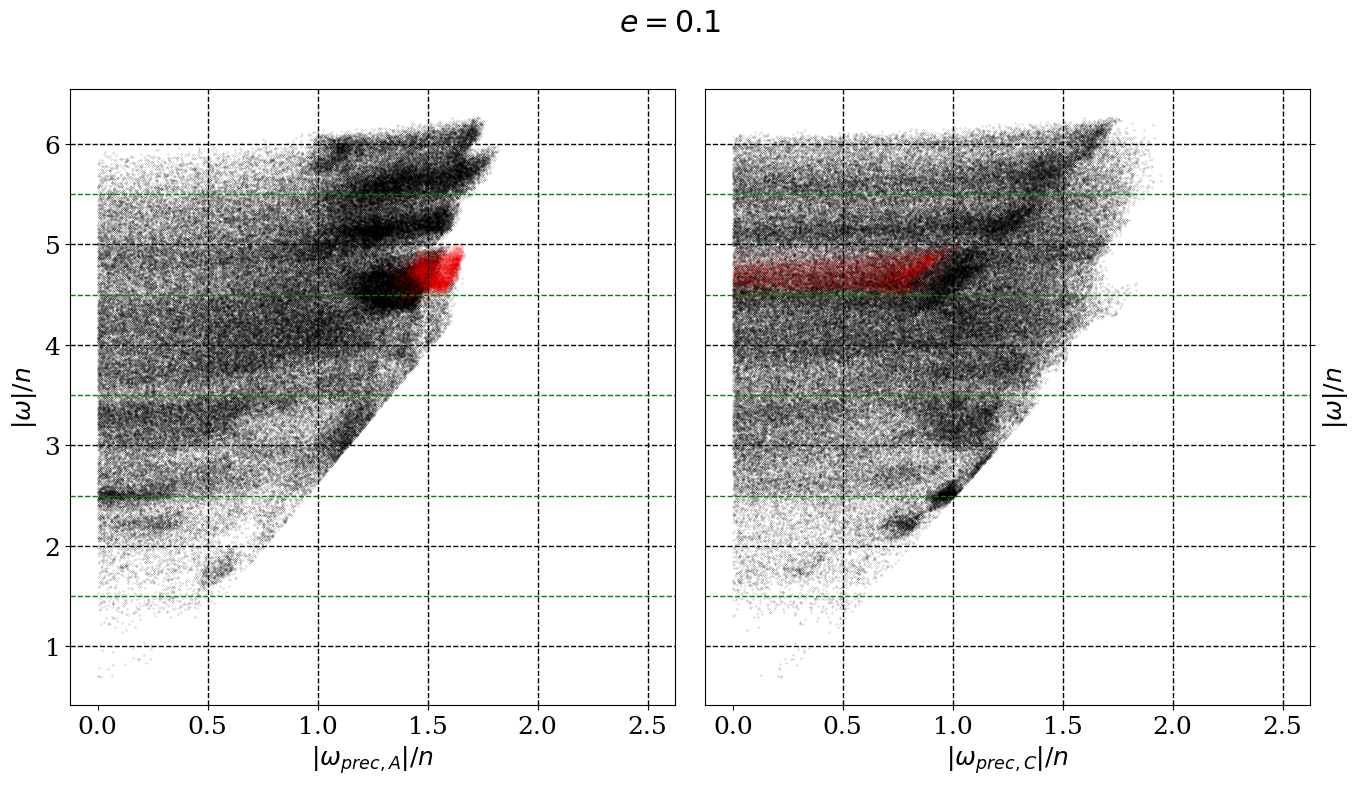

In [13]:
sim = get_sim((0.1, 0.0))

range_ = ~sim.sol.npa_mask & (np.arange(len(sim.sol.omega)) % 10 == 0)

fig, axs = plt.subplots(1, 2, figsize=(16,8), sharex=True, sharey=True, gridspec_kw={'wspace':0.05})
for i, ax in zip(['A', 'C'], axs):
    ax.scatter(np.abs(sim.sol.omega_prec[i][range_])/sim.n, sim.sol.omega[range_]/sim.n, s=0.01, alpha=1, color='k')
    ax.scatter(np.abs(fid_sim.sol.omega_prec[i])/fid_sim.n, fid_sim.sol.omega/fid_sim.n, s=0.1, alpha=0.1, color='r')
    ax.axvline(1/2, color='k', linestyle='--', linewidth=1)
    ax.axvline(1, color='k', linestyle='--', linewidth=1)
    ax.axvline(3/2, color='k', linestyle='--', linewidth=1)
    ax.axvline(2, color='k', linestyle='--', linewidth=1)
    ax.axvline(5/2, color='k', linestyle='--', linewidth=1)

    ax.axhline(1/1, color='k', linestyle='--', linewidth=1)
    ax.axhline(2/1, color='k', linestyle='--', linewidth=1)
    ax.axhline(3/1, color='k', linestyle='--', linewidth=1)
    ax.axhline(4/1, color='k', linestyle='--', linewidth=1)
    ax.axhline(5/1, color='k', linestyle='--', linewidth=1)
    ax.axhline(6/1, color='k', linestyle='--', linewidth=1)
    ax.axhline(3/2, color='g', linestyle='--', linewidth=1)
    ax.axhline(5/2, color='g', linestyle='--', linewidth=1)
    ax.axhline(7/2, color='g', linestyle='--', linewidth=1)
    ax.axhline(9/2, color='g', linestyle='--', linewidth=1)
    ax.axhline(11/2, color='g', linestyle='--', linewidth=1)

    ax.set_xlabel(f'$|\omega_{{prec,{i}}}|/n$')
    ax.set_ylabel('$|\omega|/n$')
if e_config[1] == 0:
    fig.suptitle(f'$e = {e_config[0]}$', va='top')
else:
    fig.suptitle(f'$e = {e_config[0]} + {e_config[1]}\cdot\sin(2\pi t/20yr)$', va='top')
axs[1].yaxis.tick_right()
axs[1].yaxis.set_label_position("right")

Text(0.5, 0, 'Time (years)')

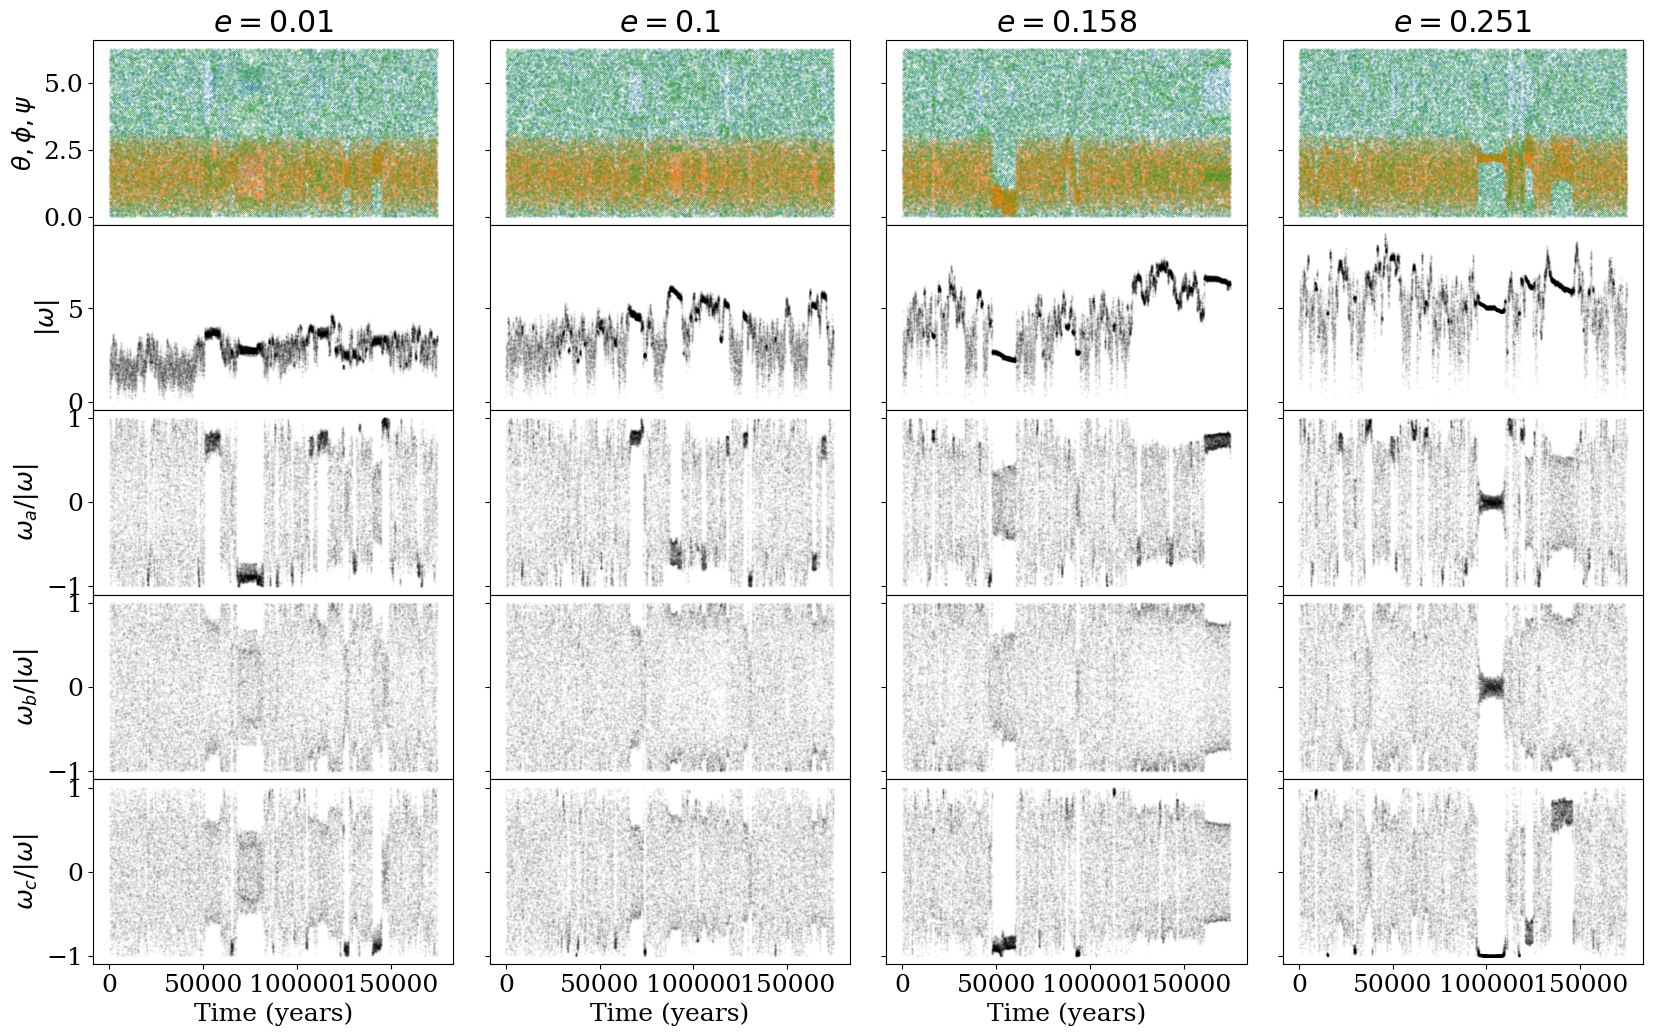

In [14]:
fig, axs = plt.subplots(5, 4, figsize=(20, 12), sharex=True, gridspec_kw={'hspace': 0, 'wspace': 0.1}, sharey='row')
thin = 100
for i, sim in enumerate(map(get_sim, [(0.01, 0.0), (0.1, 0.0), (0.158, 0.0), (0.251, 0.0)])):
    axs[0,i].scatter(sim.sol.t[::thin]/(2*np.pi)*true_P/365.25, np.remainder(sim.sol.theta[::thin], 2*np.pi), s=0.01, alpha=1, linestyle='None')
    axs[0,i].scatter(sim.sol.t[::thin]/(2*np.pi)*true_P/365.25, np.remainder(sim.sol.phi[::thin],   2*np.pi), s=0.01, alpha=1, linestyle='None')
    axs[0,i].scatter(sim.sol.t[::thin]/(2*np.pi)*true_P/365.25, np.remainder(sim.sol.psi[::thin],   2*np.pi), s=0.01, alpha=1, linestyle='None')
    axs[1,i].scatter(sim.sol.t[::thin]/(2*np.pi)*true_P/365.25, sim.sol.omega[::thin], s=0.1, alpha=0.1, color='k')
    axs[2,i].scatter(sim.sol.t[::thin]/(2*np.pi)*true_P/365.25, (sim.sol.omegaa/sim.sol.omega)[::thin], s=0.1, alpha=0.1, color='k')
    axs[3,i].scatter(sim.sol.t[::thin]/(2*np.pi)*true_P/365.25, (sim.sol.omegab/sim.sol.omega)[::thin], s=0.1, alpha=0.1, color='k')
    axs[4,i].scatter(sim.sol.t[::thin]/(2*np.pi)*true_P/365.25, (sim.sol.omegac/sim.sol.omega)[::thin], s=0.1, alpha=0.1, color='k')
    axs[0,i].set_title(r'$e = {}$'.format(sim.e_forced))
axs[0,0].set_ylabel(r'$\theta, \phi, \psi$')
axs[1,0].set_ylabel('$|\omega|$')
axs[2,0].set_ylabel('$\omega_a/|\omega|$')
axs[3,0].set_ylabel('$\omega_b/|\omega|$')
axs[4,0].set_ylabel('$\omega_c/|\omega|$')
axs[4,0].set_xlabel('Time (years)')
axs[4,1].set_xlabel('Time (years)')
axs[4,2].set_xlabel('Time (years)')

Text(0, 0.5, 'Drift in quaternion norm')

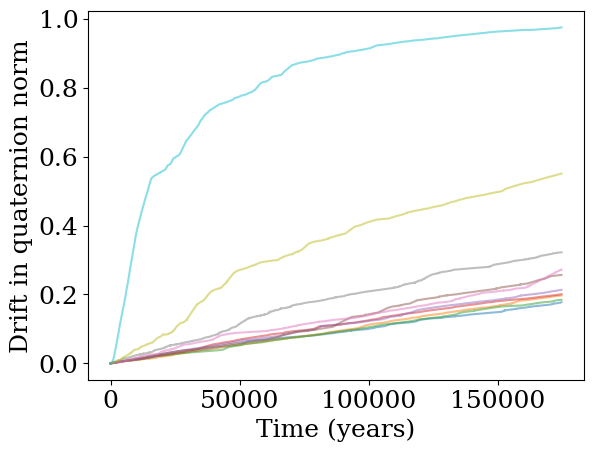

In [15]:
for sim in sims:
    plt.plot(sim.sol.t/(2*np.pi)*true_P/365.25, np.abs(np.linalg.norm(sim.sol.quat[:4], axis=0) - 1), alpha=0.5)
plt.xlabel('Time (years)')
plt.ylabel('Drift in quaternion norm')

## Animations

In [16]:
current_state = np.asarray([fid_sim.sol.quat[i] for i in range(4)]).T
np.savetxt('../figs/anim/current_state.txt', current_state, delimiter=',')

omega0 = 1.04
omegaa0 = omega0/np.sqrt(3)
omegab0 = omega0/np.sqrt(3)
omegac0 = omega0/np.sqrt(3)
initial_state = RotationalState([theta0, phi0, psi0, omegaa0, omegab0, omegac0])
tumb_short = RotationSimulation(A=0.314, B=0.474, C=0.542, e_forced=0.115, e_free=0.0, e_period=e_period, n=1.0, M0=np.radians(295))
tumb_short.integrate(ts, initial_state, coords='quat')
tumb_state = np.asarray([tumb_short.sol.quat[i] for i in range(4)]).T
np.savetxt('../figs/anim/tumb_state.txt', tumb_state, delimiter=',')

In [17]:
from matplotlib.animation import FuncAnimation

def make_animation(sim, filename, components=False):
    fig, ax = plt.subplots(figsize=(6, 3))
    fig.tight_layout(pad=1.15)
    fig.patch.set_alpha(0.0)
    ax.set_frame_on(False)
    ax.set_ylim(0, 5)
    ax.set_xlabel('Time [orbits]')
    ax.set_ylabel('$|\omega|$')
    ax.spines['bottom'].set_color('white')
    ax.spines['top'].set_color('white')
    ax.spines['left'].set_color('white')
    ax.spines['right'].set_color('white')
    ax.tick_params(axis='x', colors='white')
    ax.tick_params(axis='y', colors='white')
    ax.xaxis.label.set_color('white')
    ax.yaxis.label.set_color('white')

    line, = ax.plot([], [], lw=2, color='white')
    vline = ax.axvline(0, color='yellow', lw=1)
    if components:
        linea, = ax.plot([], [], lw=1, color='lightsalmon')
        lineb, = ax.plot([], [], lw=1, color='mediumspringgreen', linestyle='--')
        linec, = ax.plot([], [], lw=1, color='cornflowerblue', linestyle=':')

    def init():
        line.set_data([], [])
        vline.set_data([], [])
        if components:
            linea.set_data([], [])
            lineb.set_data([], [])
            linec.set_data([], [])
            return line,linea,lineb,linec
        return line,

    def animate(i):
        end = i
        start = max(0, end-200)
        times = sim.sol.t/(2*np.pi)
        ax.set_xlim(*times[[start,max(end,200)]])
        line.set_data(times[start:end], sim.sol.omega[start:end])
        vline.set_data([times[end], times[end]], [0, 1])
        if components:
            linea.set_data(times[start:end], np.abs(sim.sol.omegaa[start:end]))
            lineb.set_data(times[start:end], np.abs(sim.sol.omegab[start:end]))
            linec.set_data(times[start:end], np.abs(sim.sol.omegac[start:end]))
            return line,linea,lineb,linec
        return line,

    anim = FuncAnimation(fig, animate, init_func=init,
                                    frames=1000, interval=1000/24, blit=True)
    anim.save(filename, fps=24, codec='png', dpi=400, savefig_kwargs={'transparent': True, 'facecolor': 'none'})

# warning: these take ~1 minute each to run
# make_animation(tumb_short, '../figs/tumb_short_components.mov', components=True)
# make_animation(fid_sim, '../figs/fid_sim_components.mov', components=True)
# make_animation(tumb_short, '../figs/tumb_short.mov')
# make_animation(fid_sim, '../figs/fid_sim.mov')